# Setup Environment

In [1]:
import math, os, re, time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from tqdm.notebook import tqdm

%matplotlib inline
tqdm.pandas()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls
/kaggle/input/GiveMeSomeCredit/cs-training.csv
/kaggle/input/GiveMeSomeCredit/sampleEntry.csv
/kaggle/input/GiveMeSomeCredit/cs-test.csv


# Load Data

In [2]:
train = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-training.csv', index_col=0)
test = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-test.csv', index_col=0)

renamed = {'SeriousDlqin2yrs':'default_occurred',
           'RevolvingUtilizationOfUnsecuredLines':'utilization_of_unsecured_loc',
           'NumberOfTime30-59DaysPastDueNotWorse':'30_to_59_days_pastdue_count',
           'DebtRatio':'debt_ratio',
           'MonthlyIncome':'monthly_income',
           'NumberOfOpenCreditLinesAndLoans':'open_loc_and_loan_count',
           'NumberOfTimes90DaysLate':'90_days_late_count',
           'NumberRealEstateLoansOrLines':'re_loans_and_lines_count',
           'NumberOfTime60-89DaysPastDueNotWorse':'60_to_89_days_pastdue_count',
           'NumberOfDependents':'dependents'}

train.rename(columns=renamed, inplace=True)
test.rename(columns=renamed, inplace=True)

train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,monthly_income,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [3]:
print(train.info(),'\n')
print(train.isna().sum())
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   default_occurred              150000 non-null  int64  
 1   utilization_of_unsecured_loc  150000 non-null  float64
 2   age                           150000 non-null  int64  
 3   30_to_59_days_pastdue_count   150000 non-null  int64  
 4   debt_ratio                    150000 non-null  float64
 5   monthly_income                120269 non-null  float64
 6   open_loc_and_loan_count       150000 non-null  int64  
 7   90_days_late_count            150000 non-null  int64  
 8   re_loans_and_lines_count      150000 non-null  int64  
 9   60_to_89_days_pastdue_count   150000 non-null  int64  
 10  dependents                    146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB
None 

default_occurred                    0
utilization_o

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,monthly_income,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [4]:
print(test.info(),'\n')
print(test.isna().sum())
test.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   default_occurred              0 non-null       float64
 1   utilization_of_unsecured_loc  101503 non-null  float64
 2   age                           101503 non-null  int64  
 3   30_to_59_days_pastdue_count   101503 non-null  int64  
 4   debt_ratio                    101503 non-null  float64
 5   monthly_income                81400 non-null   float64
 6   open_loc_and_loan_count       101503 non-null  int64  
 7   90_days_late_count            101503 non-null  int64  
 8   re_loans_and_lines_count      101503 non-null  int64  
 9   60_to_89_days_pastdue_count   101503 non-null  int64  
 10  dependents                    98877 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 9.3 MB
None 

default_occurred                101503
utilization_o

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,monthly_income,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents
count,0.0,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,NaN,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,NaN,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,NaN,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,NaN,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,NaN,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.000000


# EDA

<AxesSubplot:xlabel='default_occurred', ylabel='count'>

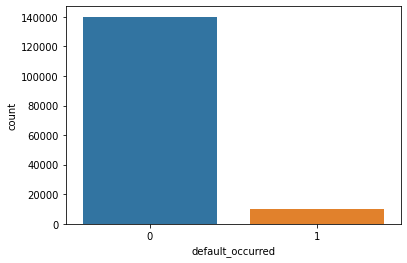

In [5]:
sns.countplot(x='default_occurred', data=train)

<AxesSubplot:>

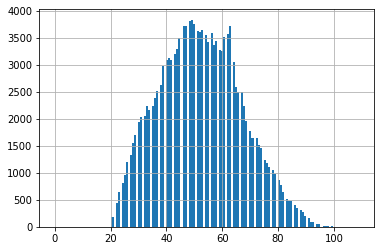

In [6]:
train['age'].hist(bins=150)

<AxesSubplot:>

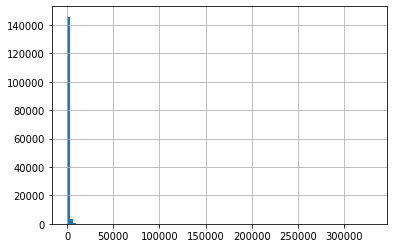

In [7]:
train['debt_ratio'].hist(bins=100)

<AxesSubplot:>

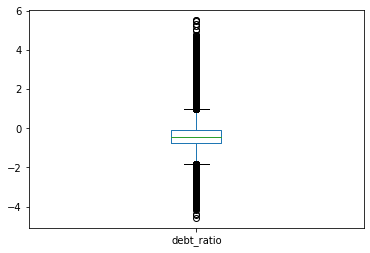

In [8]:
train['debt_ratio'].apply(lambda x: np.log10(x)).plot.box()

<AxesSubplot:>

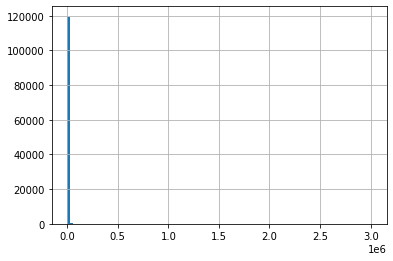

In [9]:
train['monthly_income'].hist(bins=100)

<AxesSubplot:>

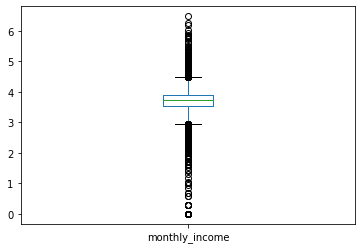

In [10]:
train['monthly_income'].apply(lambda x: np.log10(x)).plot.box()

<AxesSubplot:>

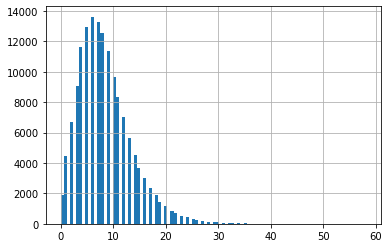

In [11]:
train['open_loc_and_loan_count'].hist(bins=100)

<AxesSubplot:>

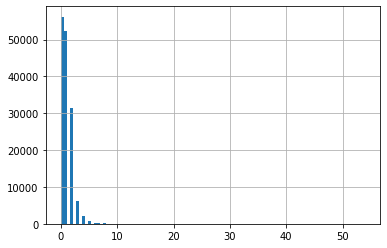

In [12]:
train['re_loans_and_lines_count'].hist(bins=100)

<AxesSubplot:>

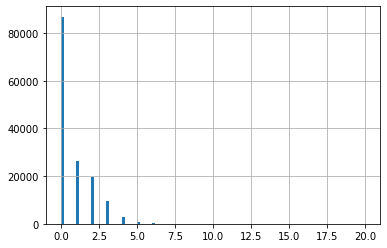

In [13]:
train['dependents'].hist(bins=100)

<AxesSubplot:xlabel='30_to_59_days_pastdue_count', ylabel='count'>

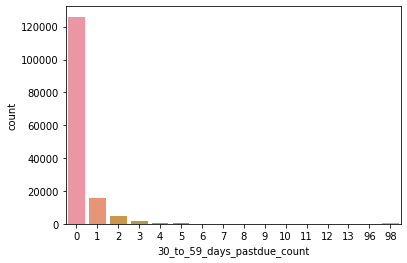

In [14]:
sns.countplot(x='30_to_59_days_pastdue_count', data=train)

<AxesSubplot:xlabel='60_to_89_days_pastdue_count', ylabel='count'>

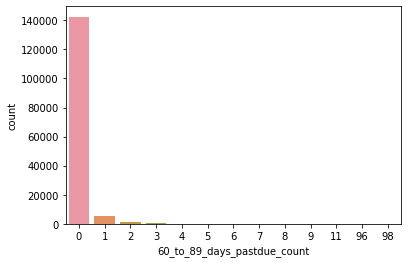

In [15]:
sns.countplot(x='60_to_89_days_pastdue_count', data=train)

<AxesSubplot:xlabel='90_days_late_count', ylabel='count'>

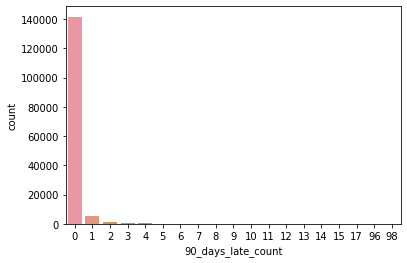

In [16]:
sns.countplot(x='90_days_late_count', data=train)

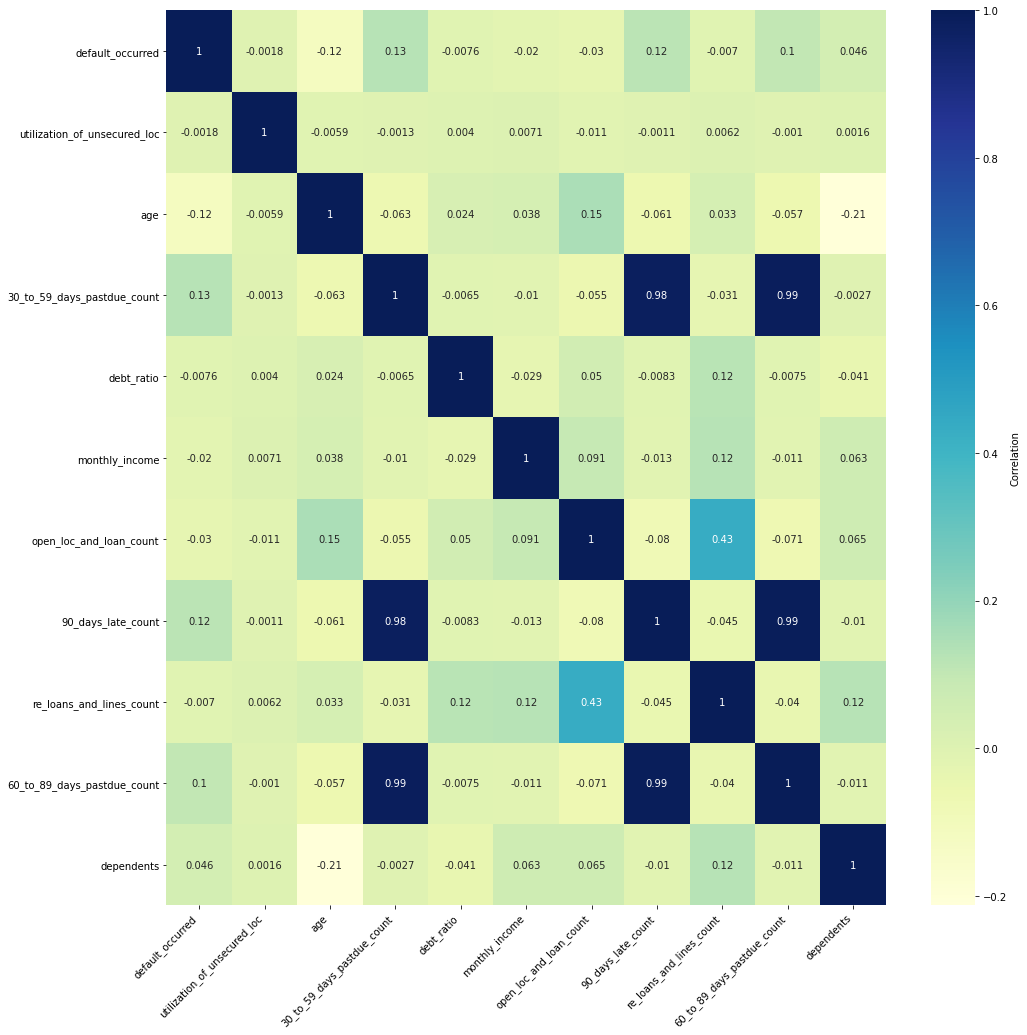

<Figure size 432x288 with 0 Axes>

In [17]:
# Correlation Matrix (Heatmap)
corr = train.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

# Data Cleaning & Feature Engineering

## Fill 'dependents' NaN values with 0

In [18]:
train['dependents'].fillna(value=0, inplace=True)
train['dependents'] = train['dependents'].apply(int)

test['dependents'].fillna(value=0, inplace=True)
test['dependents'] = test['dependents'].apply(int)

train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,monthly_income,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0


## Binning and One-Hot Encoding Income Levels

In [19]:
def income_binned(data):
    if np.isnan(data):
        return 0
    
    elif data <= 20000:
        return 1
    
    elif data <= 40000:
        return 2
    
    elif data <= 60000:
        return 3
    
    elif data <= 80000:
        return 4
    
    elif data <= 100000:
        return 5
    
    else:
        return 6

In [20]:
train['monthly_income_binned'] = train['monthly_income'].apply(income_binned)
test['monthly_income_binned'] = test['monthly_income'].apply(income_binned)

train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,monthly_income,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents,monthly_income_binned
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2,1
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1,1
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0,1
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0,1
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0,1
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2,1
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0,0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0,1


In [21]:
train.drop(columns=['monthly_income'], inplace=True)
test.drop(columns=['monthly_income'], inplace=True)

train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents,monthly_income_binned
1,1,0.766127,45,2,0.802982,13,0,6,0,2,1
2,0,0.957151,40,0,0.121876,4,0,0,0,1,1
3,0,0.658180,38,1,0.085113,2,1,0,0,0,1
4,0,0.233810,30,0,0.036050,5,0,0,0,0,1
5,0,0.907239,49,1,0.024926,7,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,4,0,1,0,0,1
149997,0,0.299745,44,0,0.716562,4,0,1,0,2,1
149998,0,0.246044,58,0,3870.000000,18,0,1,0,0,0
149999,0,0.000000,30,0,0.000000,4,0,0,0,0,1


In [22]:
dummy_names = ['monthly_income_binned_' + str(i) for i in range(1,7)]

one_hot_encoded = pd.get_dummies(train['monthly_income_binned'], drop_first=True)
one_hot_encoded.columns = dummy_names

train = pd.concat([train, one_hot_encoded], axis=1)
train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents,monthly_income_binned,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
1,1,0.766127,45,2,0.802982,13,0,6,0,2,1,1,0,0,0,0,0
2,0,0.957151,40,0,0.121876,4,0,0,0,1,1,1,0,0,0,0,0
3,0,0.658180,38,1,0.085113,2,1,0,0,0,1,1,0,0,0,0,0
4,0,0.233810,30,0,0.036050,5,0,0,0,0,1,1,0,0,0,0,0
5,0,0.907239,49,1,0.024926,7,0,1,0,0,4,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,4,0,1,0,0,1,1,0,0,0,0,0
149997,0,0.299745,44,0,0.716562,4,0,1,0,2,1,1,0,0,0,0,0
149998,0,0.246044,58,0,3870.000000,18,0,1,0,0,0,0,0,0,0,0,0
149999,0,0.000000,30,0,0.000000,4,0,0,0,0,1,1,0,0,0,0,0


In [23]:
one_hot_encoded = pd.get_dummies(test['monthly_income_binned'], drop_first=True)
one_hot_encoded.columns = dummy_names

test = pd.concat([test, one_hot_encoded], axis=1)
test

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents,monthly_income_binned,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
1,NaN,0.885519,43,0,0.177513,4,0,0,0,0,1,1,0,0,0,0,0
2,NaN,0.463295,57,0,0.527237,15,0,4,0,2,1,1,0,0,0,0,0
3,NaN,0.043275,59,0,0.687648,12,0,1,0,2,1,1,0,0,0,0,0
4,NaN,0.280308,38,1,0.925961,7,0,2,0,0,1,1,0,0,0,0,0
5,NaN,1.000000,27,0,0.019917,4,0,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101499,NaN,0.282653,24,0,0.068522,5,0,0,0,0,1,1,0,0,0,0,0
101500,NaN,0.922156,36,3,0.934217,8,0,2,0,4,1,1,0,0,0,0,0
101501,NaN,0.081596,70,0,836.000000,3,0,0,0,0,0,0,0,0,0,0,0
101502,NaN,0.335457,56,0,3568.000000,8,0,2,1,3,0,0,0,0,0,0,0


In [24]:
train.drop(columns=['monthly_income_binned'], inplace=True)
test.drop(columns=['monthly_income_binned'], inplace=True)

train

,default_occurred,utilization_of_unsecured_loc,age,30_to_59_days_pastdue_count,debt_ratio,open_loc_and_loan_count,90_days_late_count,re_loans_and_lines_count,60_to_89_days_pastdue_count,dependents,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
1,1,0.766127,45,2,0.802982,13,0,6,0,2,1,0,0,0,0,0
2,0,0.957151,40,0,0.121876,4,0,0,0,1,1,0,0,0,0,0
3,0,0.658180,38,1,0.085113,2,1,0,0,0,1,0,0,0,0,0
4,0,0.233810,30,0,0.036050,5,0,0,0,0,1,0,0,0,0,0
5,0,0.907239,49,1,0.024926,7,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,4,0,1,0,0,1,0,0,0,0,0
149997,0,0.299745,44,0,0.716562,4,0,1,0,2,1,0,0,0,0,0
149998,0,0.246044,58,0,3870.000000,18,0,1,0,0,0,0,0,0,0,0
149999,0,0.000000,30,0,0.000000,4,0,0,0,0,1,0,0,0,0,0


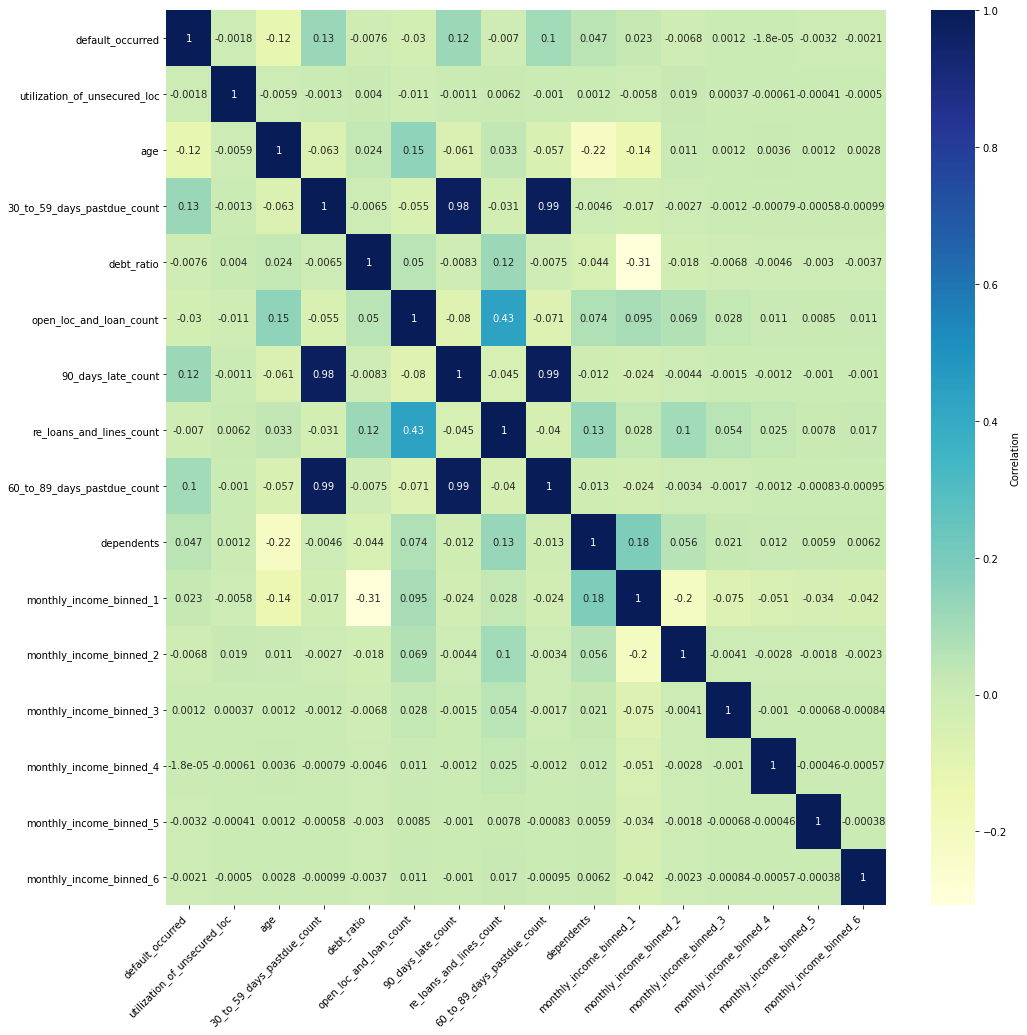

<Figure size 432x288 with 0 Axes>

In [25]:
# Correlation Matrix (Heatmap)
corr = train.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

# Aggregate Past Due Counts

In [26]:
train['above_30_days_pastdue_count'] = train['30_to_59_days_pastdue_count'] + train['60_to_89_days_pastdue_count'] + train['90_days_late_count']
train.drop(columns=['30_to_59_days_pastdue_count',
                    '60_to_89_days_pastdue_count',
                    '90_days_late_count'], inplace=True)

train

,default_occurred,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6,above_30_days_pastdue_count
1,1,0.766127,45,0.802982,13,6,2,1,0,0,0,0,0,2
2,0,0.957151,40,0.121876,4,0,1,1,0,0,0,0,0,0
3,0,0.658180,38,0.085113,2,0,0,1,0,0,0,0,0,2
4,0,0.233810,30,0.036050,5,0,0,1,0,0,0,0,0,0
5,0,0.907239,49,0.024926,7,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0.225131,4,1,0,1,0,0,0,0,0,0
149997,0,0.299745,44,0.716562,4,1,2,1,0,0,0,0,0,0
149998,0,0.246044,58,3870.000000,18,1,0,0,0,0,0,0,0,0
149999,0,0.000000,30,0.000000,4,0,0,1,0,0,0,0,0,0


In [27]:
test['above_30_days_pastdue_count'] = test['30_to_59_days_pastdue_count'] + test['60_to_89_days_pastdue_count'] + test['90_days_late_count']
test.drop(columns=['30_to_59_days_pastdue_count',
                   '60_to_89_days_pastdue_count',
                   '90_days_late_count'], inplace=True)

test

,default_occurred,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6,above_30_days_pastdue_count
1,NaN,0.885519,43,0.177513,4,0,0,1,0,0,0,0,0,0
2,NaN,0.463295,57,0.527237,15,4,2,1,0,0,0,0,0,0
3,NaN,0.043275,59,0.687648,12,1,2,1,0,0,0,0,0,0
4,NaN,0.280308,38,0.925961,7,2,0,1,0,0,0,0,0,1
5,NaN,1.000000,27,0.019917,4,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101499,NaN,0.282653,24,0.068522,5,0,0,1,0,0,0,0,0,0
101500,NaN,0.922156,36,0.934217,8,2,4,1,0,0,0,0,0,3
101501,NaN,0.081596,70,836.000000,3,0,0,0,0,0,0,0,0,0
101502,NaN,0.335457,56,3568.000000,8,2,3,0,0,0,0,0,0,1


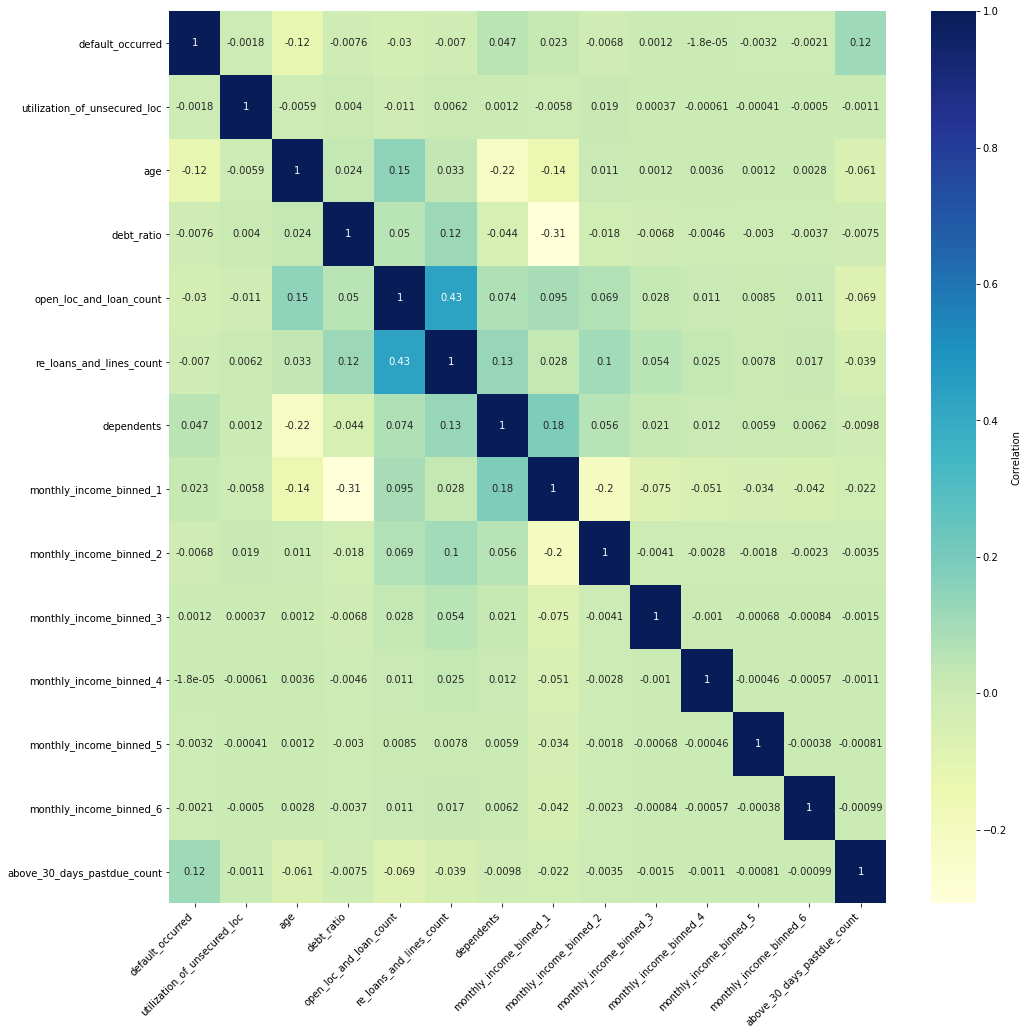

<Figure size 432x288 with 0 Axes>

In [28]:
# Correlation Matrix (Heatmap)
corr = train.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

# Train-Validation Split (before Resampling)

In [29]:
X = train.iloc[:,1:]
y = train.iloc[:,0:1]

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  shuffle=True, 
                                                  stratify=y,
                                                  random_state=42)
X_train

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6,above_30_days_pastdue_count
57837,0.114987,62,1841.000000,5,1,2,0,0,0,0,0,0,0
132896,0.008705,73,0.498553,6,1,0,1,0,0,0,0,0,0
27982,0.214501,32,0.211999,8,0,2,1,0,0,0,0,0,0
37853,1.000000,60,118.000000,5,0,0,0,0,0,0,0,0,0
103814,0.230493,60,1.017328,10,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18049,0.004136,41,0.472323,9,2,0,1,0,0,0,0,0,0
3896,0.000000,49,0.322344,18,1,1,1,0,0,0,0,0,0
109981,1.000000,80,35.000000,0,0,0,0,0,0,0,0,0,0
74355,0.925187,63,0.389974,2,0,0,1,0,0,0,0,0,1


In [30]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(120000, 13)
(30000, 13)
(120000, 1)
(30000, 1)


# Resampling (for Imbalanced Dataset)

<AxesSubplot:xlabel='default_occurred', ylabel='count'>

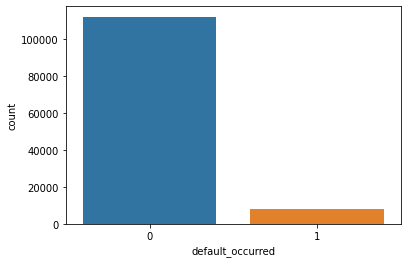

In [31]:
sns.countplot(x='default_occurred',data=y_train)

In [32]:
smote = SMOTE(sampling_strategy=30/70, random_state=42, n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='default_occurred', ylabel='count'>

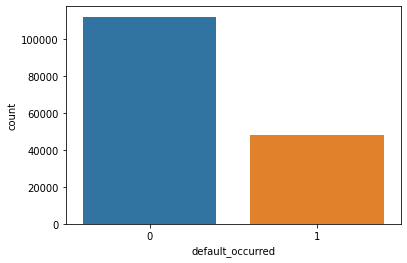

In [33]:
sns.countplot(x='default_occurred',data=y_train)

# Feature Scaling

In [34]:
X_train = pd.concat([X_train.iloc[:,:6],
                     X_train.iloc[:,-1],
                     X_train.iloc[:,6:-1]],axis=1)
X_val = pd.concat([X_val.iloc[:,:6],
                   X_val.iloc[:,-1],
                   X_val.iloc[:,6:-1]],axis=1)

X_train

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,above_30_days_pastdue_count,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
0,0.114987,62,1841.000000,5,1,2,0,0,0,0,0,0,0
1,0.008705,73,0.498553,6,1,0,0,1,0,0,0,0,0
2,0.214501,32,0.211999,8,0,2,0,1,0,0,0,0,0
3,1.000000,60,118.000000,5,0,0,0,0,0,0,0,0,0
4,0.230493,60,1.017328,10,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159965,1.000000,28,0.004995,0,0,0,1,1,0,0,0,0,0
159966,0.768188,53,1513.807732,7,1,0,2,0,0,0,0,0,0
159967,0.546685,52,0.397511,21,1,0,0,1,0,0,0,0,0
159968,1.034371,40,0.487426,15,1,0,12,1,0,0,0,0,0


In [35]:
X_val

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,above_30_days_pastdue_count,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
10683,0.019252,66,0.433926,13,1,0,0,1,0,0,0,0,0
40174,0.454221,78,0.873533,7,1,2,0,1,0,0,0,0,0
4720,0.077572,59,0.172882,5,1,0,0,1,0,0,0,0,0
81731,0.107864,59,0.453692,10,2,0,0,1,0,0,0,0,0
113640,0.101095,67,0.407831,14,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64333,0.011259,75,18.000000,8,0,0,0,1,0,0,0,0,0
10479,0.195226,27,0.089255,5,0,0,1,1,0,0,0,0,0
26359,0.047229,31,0.887351,5,1,0,0,1,0,0,0,0,0
34189,0.035643,80,0.147694,7,1,1,0,1,0,0,0,0,0


In [36]:
scaler = StandardScaler()
scale_vars = X_train.loc[:,:'above_30_days_pastdue_count'].columns

# Fit and Scale X_train
scaled = pd.DataFrame(scaler.fit_transform(X_train.loc[:,:'above_30_days_pastdue_count'].copy()), columns=scale_vars, index=X_train.index)
X_train = pd.concat([scaled,X_train.loc[:,'monthly_income_binned_1':]], axis=1)

# Scale X_var using the X_train fitted scaler (prevents data leakage)
scaled = pd.DataFrame(scaler.transform(X_val.loc[:,:'above_30_days_pastdue_count'].copy()), columns=scale_vars, index=X_val.index)
X_val = pd.concat([scaled,X_val.loc[:,'monthly_income_binned_1':]], axis=1)

X_train

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,above_30_days_pastdue_count,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
0,-0.024515,0.778324,0.799599,-0.614082,0.037107,1.162028,-0.106067,0,0,0,0,0,0
1,-0.024984,1.534133,-0.175887,-0.423259,0.037107,-0.672279,-0.106067,1,0,0,0,0,0
2,-0.024076,-1.282974,-0.176039,-0.041613,-0.827814,1.162028,-0.106067,1,0,0,0,0,0
3,-0.020612,0.640904,-0.113610,-0.614082,-0.827814,-0.672279,-0.106067,0,0,0,0,0,0
4,-0.024006,0.640904,-0.175612,0.340033,0.037107,-0.672279,-0.106067,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159965,-0.020612,-1.557813,-0.176149,-1.568197,-0.827814,-0.672279,-0.057580,1,0,0,0,0,0
159966,-0.021634,0.159935,0.626183,-0.232436,0.037107,-0.672279,-0.009093,0,0,0,0,0,0
159967,-0.022611,0.091225,-0.175941,2.439086,0.037107,-0.672279,-0.106067,1,0,0,0,0,0
159968,-0.020460,-0.733294,-0.175893,1.294148,0.037107,-0.672279,0.475777,1,0,0,0,0,0


In [37]:
X_val

,utilization_of_unsecured_loc,age,debt_ratio,open_loc_and_loan_count,re_loans_and_lines_count,dependents,above_30_days_pastdue_count,monthly_income_binned_1,monthly_income_binned_2,monthly_income_binned_3,monthly_income_binned_4,monthly_income_binned_5,monthly_income_binned_6
10683,-0.024938,1.053164,-0.175921,0.912502,0.037107,-0.672279,-0.106067,1,0,0,0,0,0
40174,-0.023019,1.877683,-0.175688,-0.232436,0.037107,1.162028,-0.106067,1,0,0,0,0,0
4720,-0.024680,0.572194,-0.176060,-0.614082,0.037107,-0.672279,-0.106067,1,0,0,0,0,0
81731,-0.024547,0.572194,-0.175911,0.340033,0.902027,-0.672279,-0.106067,1,0,0,0,0,0
113640,-0.024577,1.121874,-0.175935,1.103325,0.902027,-0.672279,-0.106067,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64333,-0.024973,1.671553,-0.166611,-0.041613,-0.827814,-0.672279,-0.106067,1,0,0,0,0,0
10479,-0.024161,-1.626523,-0.176104,-0.614082,-0.827814,-0.672279,-0.057580,1,0,0,0,0,0
26359,-0.024814,-1.351684,-0.175681,-0.614082,0.037107,-0.672279,-0.106067,1,0,0,0,0,0
34189,-0.024865,2.015103,-0.176073,-0.232436,0.037107,0.244874,-0.106067,1,0,0,0,0,0


# Modelling

## Logistic Regression (Baseline, Untuned)

In [38]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [39]:
logreg = LogisticRegressionCV(scoring='roc_auc', max_iter=500, random_state=42)
logreg.fit(X_train, y_train.values.ravel())

y_pred = logreg.predict(X_val)
y_proba = logreg.predict_proba(X_val)[:,1]

recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
auroc = roc_auc_score(y_val, y_proba)

print("Recall Score =", recall)
print("Precision Score =", precision)
print("AUROC Score =", auroc)
print('\n', classification_report(y_val, y_pred))

Recall Score = 0.23690773067331672
Precision Score = 0.49120992761116855
AUROC Score = 0.7631581432202669

               precision    recall  f1-score   support

           0       0.95      0.98      0.96     27995
           1       0.49      0.24      0.32      2005

    accuracy                           0.93     30000
   macro avg       0.72      0.61      0.64     30000
weighted avg       0.92      0.93      0.92     30000



AUROC: 0.7631581432202669


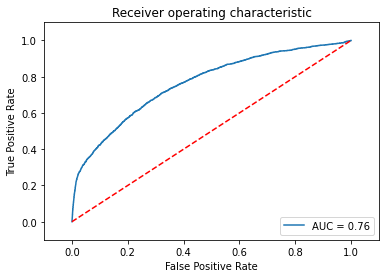

<Figure size 432x288 with 0 Axes>

In [40]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
print('AUROC:', roc_auc)

plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])

plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()
plt.clf()

## Logistic Regression (Tuned)

In [41]:
logreg = LogisticRegressionCV(max_iter=500, random_state=42)

paramGrid = {
    'penalty': ['l1','l2']
}

best_logreg = GridSearchCV(estimator=logreg, param_grid=paramGrid, cv=5, scoring='roc_auc', n_jobs=-1)
best_logreg.fit(X_train, y_train.values.ravel())

y_pred = best_logreg.predict(X_val)
y_proba = best_logreg.predict_proba(X_val)[:,1]

recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
auroc = roc_auc_score(y_val, y_proba)

print("Recall Score =", recall)
print("Precision Score =", precision)
print("AUROC Score =", auroc)
print('\n', classification_report(y_val, y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.75264263]
  category=UserWarning


Recall Score = 0.23690773067331672
Precision Score = 0.49120992761116855
AUROC Score = 0.7631378510323584

               precision    recall  f1-score   support

           0       0.95      0.98      0.96     27995
           1       0.49      0.24      0.32      2005

    accuracy                           0.93     30000
   macro avg       0.72      0.61      0.64     30000
weighted avg       0.92      0.93      0.92     30000



AUROC: 0.7631378510323584


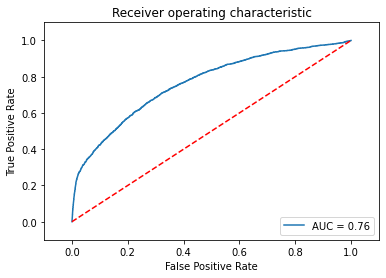

<Figure size 432x288 with 0 Axes>

In [42]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
print('AUROC:', roc_auc)

plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])

plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()
plt.clf()

## Random Forest

In [43]:
%%time
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

paramGrid = {
    'n_estimators': [i*100 for i in range(1,11)],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30]
}

best_rfc = RandomizedSearchCV(estimator=rfc,
                              param_distributions=paramGrid,
                              n_iter=10, 
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                              random_state=42)
best_rfc.fit(X_train, y_train.values.ravel())

y_pred = best_rfc.predict(X_val)
y_proba = best_rfc.predict_proba(X_val)[:,1]

recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
auroc = roc_auc_score(y_val, y_proba)

print("Recall Score =", recall)
print("Precision Score =", precision)
print("AUROC Score =", auroc)
print('\n', classification_report(y_val, y_pred))

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Recall Score = 0.4498753117206983
Precision Score = 0.3096464126330244
AUROC Score = 0.830732759100641

               precision    recall  f1-score   support

           0       0.96      0.93      0.94     27995
           1       0.31      0.45      0.37      2005

    accuracy                           0.90     30000
   macro avg       0.63      0.69      0.66     30000
weighted avg       0.92      0.90      0.90     30000

CPU times: user 6min 19s, sys: 3.58 s, total: 6min 22s
Wall time: 32min 56s


AUROC: 0.830732759100641


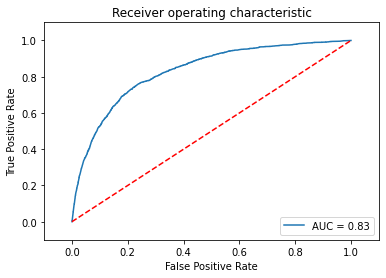

<Figure size 432x288 with 0 Axes>

In [44]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
print('AUROC:', roc_auc)

plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])

plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()
plt.clf()

In [45]:
best_rfc.best_params_

{'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 40}

## XGBoost

#### RandomizedSearchCV (takes too long)

In [46]:
# %%time
# xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42)

# paramGrid = {
#     'n_estimators': [i*100 for i in range(1,11)],
#     'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
#     'subsample': [0.7, 0.8, 0.9, 1],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'reg_alpha': [0, 0.001, 0.005 , 0.01, 0.05, 0.1, 0.5, 1],
#     'reg_lambda': [0, 0.001, 0.005 , 0.01, 0.05, 0.1, 0.5, 1],
# }

# best_xgb = RandomizedSearchCV(estimator=xgb, 
#                               param_distributions=paramGrid, 
#                               n_iter=1,
#                               scoring='roc_auc',
#                               n_jobs=-1, 
#                               cv=5, 
#                               random_state=42)
# best_xgb.fit(X_train, y_train.values.ravel())

# y_pred = best_xgb.predict(X_val)
# y_proba = best_xgb.predict_proba(X_val)[:,1]

# recall = recall_score(y_val, y_pred)
# precision = precision_score(y_val, y_pred)
# auroc = roc_auc_score(y_val, y_proba)

# print("Recall Score =", recall)
# print("Precision Score =", precision)
# print("AUROC Score =", auroc)
# print('\n', classification_report(y_val, y_pred))

### Manual Tuning

#### n_estimators

In [47]:
%%time
error_metrics = []

for i in tqdm([i*100 for i in range(1,11)]):
    xgb = XGBClassifier(n_estimators=i,
                        objective='binary:logistic', 
                        use_label_encoder=False,
                        n_jobs=-1, 
                        random_state=42)
    xgb.fit(X_train, y_train.values.ravel())

    y_pred = xgb.predict(X_val)
    y_proba = xgb.predict_proba(X_val)[:,1]

    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    auroc = roc_auc_score(y_val, y_proba)
    
    error_metrics.append({'n_estimators': i,
                          'recall': recall,
                          'precision': precision,
                          'auroc': auroc})

error_metrics = pd.DataFrame(error_metrics)
error_metrics

  0%|          | 0/10 [00:00<?, ?it/s]

[05:13:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:14:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:14:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,n_estimators,recall,precision,auroc
0,100,0.535162,0.305003,0.839848
1,200,0.509726,0.293425,0.830171
2,300,0.501746,0.291257,0.823872
3,400,0.493766,0.289728,0.819517
4,500,0.484788,0.286303,0.815911
5,600,0.484788,0.283299,0.811917
6,700,0.483292,0.281932,0.809978
7,800,0.476808,0.281591,0.807029
8,900,0.470823,0.277565,0.805958
9,1000,0.471322,0.277696,0.803988


#### learning_rate

In [48]:
%%time
error_metrics = []

for lr in tqdm([0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    xgb = XGBClassifier(n_estimators=100,
                        learning_rate=lr,
                        objective='binary:logistic', 
                        use_label_encoder=False,
                        n_jobs=-1, 
                        random_state=42)
    xgb.fit(X_train, y_train.values.ravel())

    y_pred = xgb.predict(X_val)
    y_proba = xgb.predict_proba(X_val)[:,1]

    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    auroc = roc_auc_score(y_val, y_proba)
    
    error_metrics.append({'learning_rate': lr,
                          'recall': recall,
                          'precision': precision,
                          'auroc': auroc})

error_metrics = pd.DataFrame(error_metrics)
error_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

[05:21:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:21:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:21:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:21:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,learning_rate,recall,precision,auroc
0,0.05,0.555611,0.324403,0.854150
1,0.10,0.543142,0.316019,0.849462
2,0.15,0.540648,0.311405,0.846049
3,0.20,0.536160,0.312318,0.843217
4,0.25,0.526185,0.303422,0.841122
5,0.30,0.535162,0.305003,0.839848


In [49]:
%%time
error_metrics = []

for md in tqdm([None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]):
    xgb = XGBClassifier(n_estimators=100,
                        learning_rate=0.05,
                        max_depth=md,
                        objective='binary:logistic', 
                        use_label_encoder=False,
                        n_jobs=-1, 
                        random_state=42)
    xgb.fit(X_train, y_train.values.ravel())

    y_pred = xgb.predict(X_val)
    y_proba = xgb.predict_proba(X_val)[:,1]

    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    auroc = roc_auc_score(y_val, y_proba)
    
    error_metrics.append({'max_depth': md,
                          'recall': recall,
                          'precision': precision,
                          'auroc': auroc})

error_metrics = pd.DataFrame(error_metrics)
error_metrics

  0%|          | 0/11 [00:00<?, ?it/s]

[05:21:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:22:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:22:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:22:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,max_depth,recall,precision,auroc
0,NaN,0.555611,0.324403,0.854150
1,5.0,0.555112,0.331250,0.855521
2,10.0,0.530673,0.311841,0.842902
3,15.0,0.481796,0.300841,0.827887
4,20.0,0.449377,0.286669,0.822524
5,25.0,0.441397,0.283472,0.820193
6,30.0,0.436908,0.280859,0.819055
7,35.0,0.437406,0.281451,0.818594
8,40.0,0.432918,0.279639,0.818728
9,45.0,0.436409,0.281985,0.819763


#### subsample

In [50]:
%%time
error_metrics = []

for ss in tqdm([0.7, 0.8, 0.9, 1]):
    xgb = XGBClassifier(n_estimators=100,
                        learning_rate=0.05,
                        objective='binary:logistic',
                        max_depth=5,
                        subsample=ss, 
                        use_label_encoder=False,
                        n_jobs=-1, 
                        random_state=42)
    xgb.fit(X_train, y_train.values.ravel())

    y_pred = xgb.predict(X_val)
    y_proba = xgb.predict_proba(X_val)[:,1]

    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    auroc = roc_auc_score(y_val, y_proba)
    
    error_metrics.append({'subsample': ss,
                          'recall': recall,
                          'precision': precision,
                          'auroc': auroc})

error_metrics = pd.DataFrame(error_metrics)
error_metrics

  0%|          | 0/4 [00:00<?, ?it/s]

[05:29:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:29:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:29:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:29:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,subsample,recall,precision,auroc
0,0.7,0.551621,0.328971,0.855533
1,0.8,0.554115,0.328698,0.855312
2,0.9,0.553616,0.328402,0.855570
3,1.0,0.555112,0.331250,0.855521


#### reg_alpha

In [51]:
%%time
error_metrics = []

for ra in tqdm([0, 0.001, 0.005 , 0.01, 0.05, 0.1, 0.5, 1]):
    xgb = XGBClassifier(n_estimators=100,
                        learning_rate=0.05,
                        objective='binary:logistic',
                        max_depth=5,
                        subsample=0.9, 
                        reg_alpha=ra,
                        use_label_encoder=False,
                        n_jobs=-1, 
                        random_state=42)
    xgb.fit(X_train, y_train.values.ravel())

    y_pred = xgb.predict(X_val)
    y_proba = xgb.predict_proba(X_val)[:,1]

    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    auroc = roc_auc_score(y_val, y_proba)
    
    error_metrics.append({'reg_alpha': ra,
                          'recall': recall,
                          'precision': precision,
                          'auroc': auroc})

error_metrics = pd.DataFrame(error_metrics)
error_metrics

  0%|          | 0/8 [00:00<?, ?it/s]

[05:29:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:29:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:29:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:30:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,reg_alpha,recall,precision,auroc
0,0.000,0.553616,0.328402,0.855570
1,0.001,0.553616,0.328402,0.855570
2,0.005,0.553616,0.330259,0.855462
3,0.010,0.556110,0.332142,0.855666
4,0.050,0.554613,0.329677,0.855323
5,0.100,0.553616,0.332734,0.855544
6,0.500,0.555112,0.332041,0.855543
7,1.000,0.557107,0.329304,0.855515


#### reg_lambda

In [52]:
%%time
error_metrics = []

for rl in tqdm([0, 0.001, 0.005 , 0.01, 0.05, 0.1, 0.5, 1]):
    xgb = XGBClassifier(n_estimators=100,
                        learning_rate=0.05,
                        objective='binary:logistic',
                        max_depth=5,
                        subsample=0.9, 
                        reg_alpha=0.01,
                        reg_lambda=rl,
                        use_label_encoder=False,
                        n_jobs=-1, 
                        random_state=42)
    xgb.fit(X_train, y_train.values.ravel())

    y_pred = xgb.predict(X_val)
    y_proba = xgb.predict_proba(X_val)[:,1]

    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    auroc = roc_auc_score(y_val, y_proba)
    
    error_metrics.append({'reg_lambda': rl,
                          'recall': recall,
                          'precision': precision,
                          'auroc': auroc})

error_metrics = pd.DataFrame(error_metrics)
error_metrics

  0%|          | 0/8 [00:00<?, ?it/s]

[05:30:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:30:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:31:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:31:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,reg_lambda,recall,precision,auroc
0,0.000,0.551122,0.331932,0.855687
1,0.001,0.551122,0.331932,0.855685
2,0.005,0.556110,0.332637,0.855517
3,0.010,0.555611,0.330760,0.855456
4,0.050,0.550623,0.328865,0.855598
5,0.100,0.554613,0.330657,0.855370
6,0.500,0.554613,0.331841,0.855878
7,1.000,0.556110,0.332142,0.855666


#### Final Model

In [53]:
xgb = XGBClassifier(n_estimators=100,
                    learning_rate=0.05,
                    objective='binary:logistic',
                    max_depth=5,
                    subsample=0.9, 
                    reg_alpha=0.01,
                    reg_lambda=0.5,
                    use_label_encoder=False,
                    n_jobs=-1, 
                    random_state=42)
xgb.fit(X_train, y_train.values.ravel())

y_pred = xgb.predict(X_val)
y_proba = xgb.predict_proba(X_val)[:,1]

recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
auroc = roc_auc_score(y_val, y_proba)

print("Recall Score =", recall)
print("Precision Score =", precision)
print("AUROC Score =", auroc)
print('\n', classification_report(y_val, y_pred))

[05:31:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Recall Score = 0.5546134663341646
Precision Score = 0.3318412414204715
AUROC Score = 0.8558779065909079

               precision    recall  f1-score   support

           0       0.97      0.92      0.94     27995
           1       0.33      0.55      0.42      2005

    accuracy                           0.90     30000
   macro avg       0.65      0.74      0.68     30000
weighted avg       0.92      0.90      0.91     30000



AUROC: 0.8558779065909079


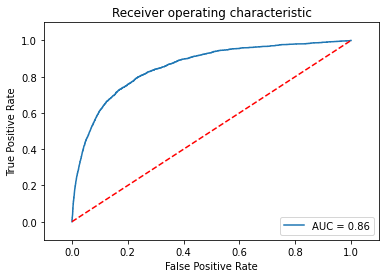

<Figure size 432x288 with 0 Axes>

In [54]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
print('AUROC:', roc_auc)

plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])

plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()
plt.clf()